# Imports

In [1]:
import sys

stdout = sys.stdout

import htsexperimentation as htsx
import tsaugmentation as tsag
import properscoring as ps
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sys.stdout = stdout
sns.set()
plt.rcParams.update({'font.size': 22})

# Parameters

In [2]:
datasets=['prison', 'tourism', 'm5']
algorithms=[
            "gpf",
            "mint",
            "deepar",
            "standard_gp_lin",
            "standard_gp_pie",
            "standard_gp_zer",
            "ets_bu",
            "arima_bu"
        ]

# Loading data
dataset = 'tourism'
data = tsag.preprocessing.PreprocessDatasets(dataset).apply_preprocess()
true = data['predict']['data'].reshape((data['predict']['s'], data['predict']['n'])).T

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


# Calculation of CRPS - example for a single series

### GPF

In [3]:
e = htsx.compute_results.get_output(dataset, 'gpf', 'jitter')
series = 9
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['samples']['bottom'][-data['h']:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

KeyError: 'predictions'

In [4]:
ps.crps_ensemble(true[-data['h']:, series], e['predictions']['samples']['bottom'][-data['h']:, series, :]).mean()

KeyError: 'predictions'

### MinT

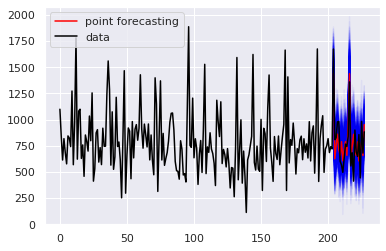

In [5]:
e = htsx.compute_results.get_output(dataset, 'mint', 'jitter')
series = 3
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['samples']['bottom'][-data['h']:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(data['train']['n'], data['predict']['n']), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')

plt.legend();

In [6]:
ps.crps_ensemble(true[-data['h']:, series], e['predictions']['samples']['bottom'][-data['h']:, series, :]).mean()

97.3618040830794

### DeepAR

ValueError: x and y must have same first dimension, but have shapes (0,) and (24, 500)

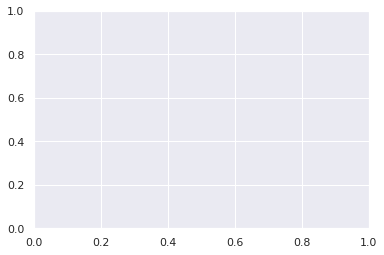

In [7]:
e = htsx.compute_results.get_output(dataset, 'deepar', 'jitter')
series = 9
plt.plot(np.arange(data['train']['n'], data['train']['n']), e['predictions']['samples']['bottom'][-data['h']:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(data['train']['n'], data['train']['n']), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [8]:
ps.crps_ensemble(true[-data['h']:, series], e['predictions']['samples']['bottom'][-data['h']:, series, :]).mean()

117.56214016666667

# Calculation of MASE for each algorithm

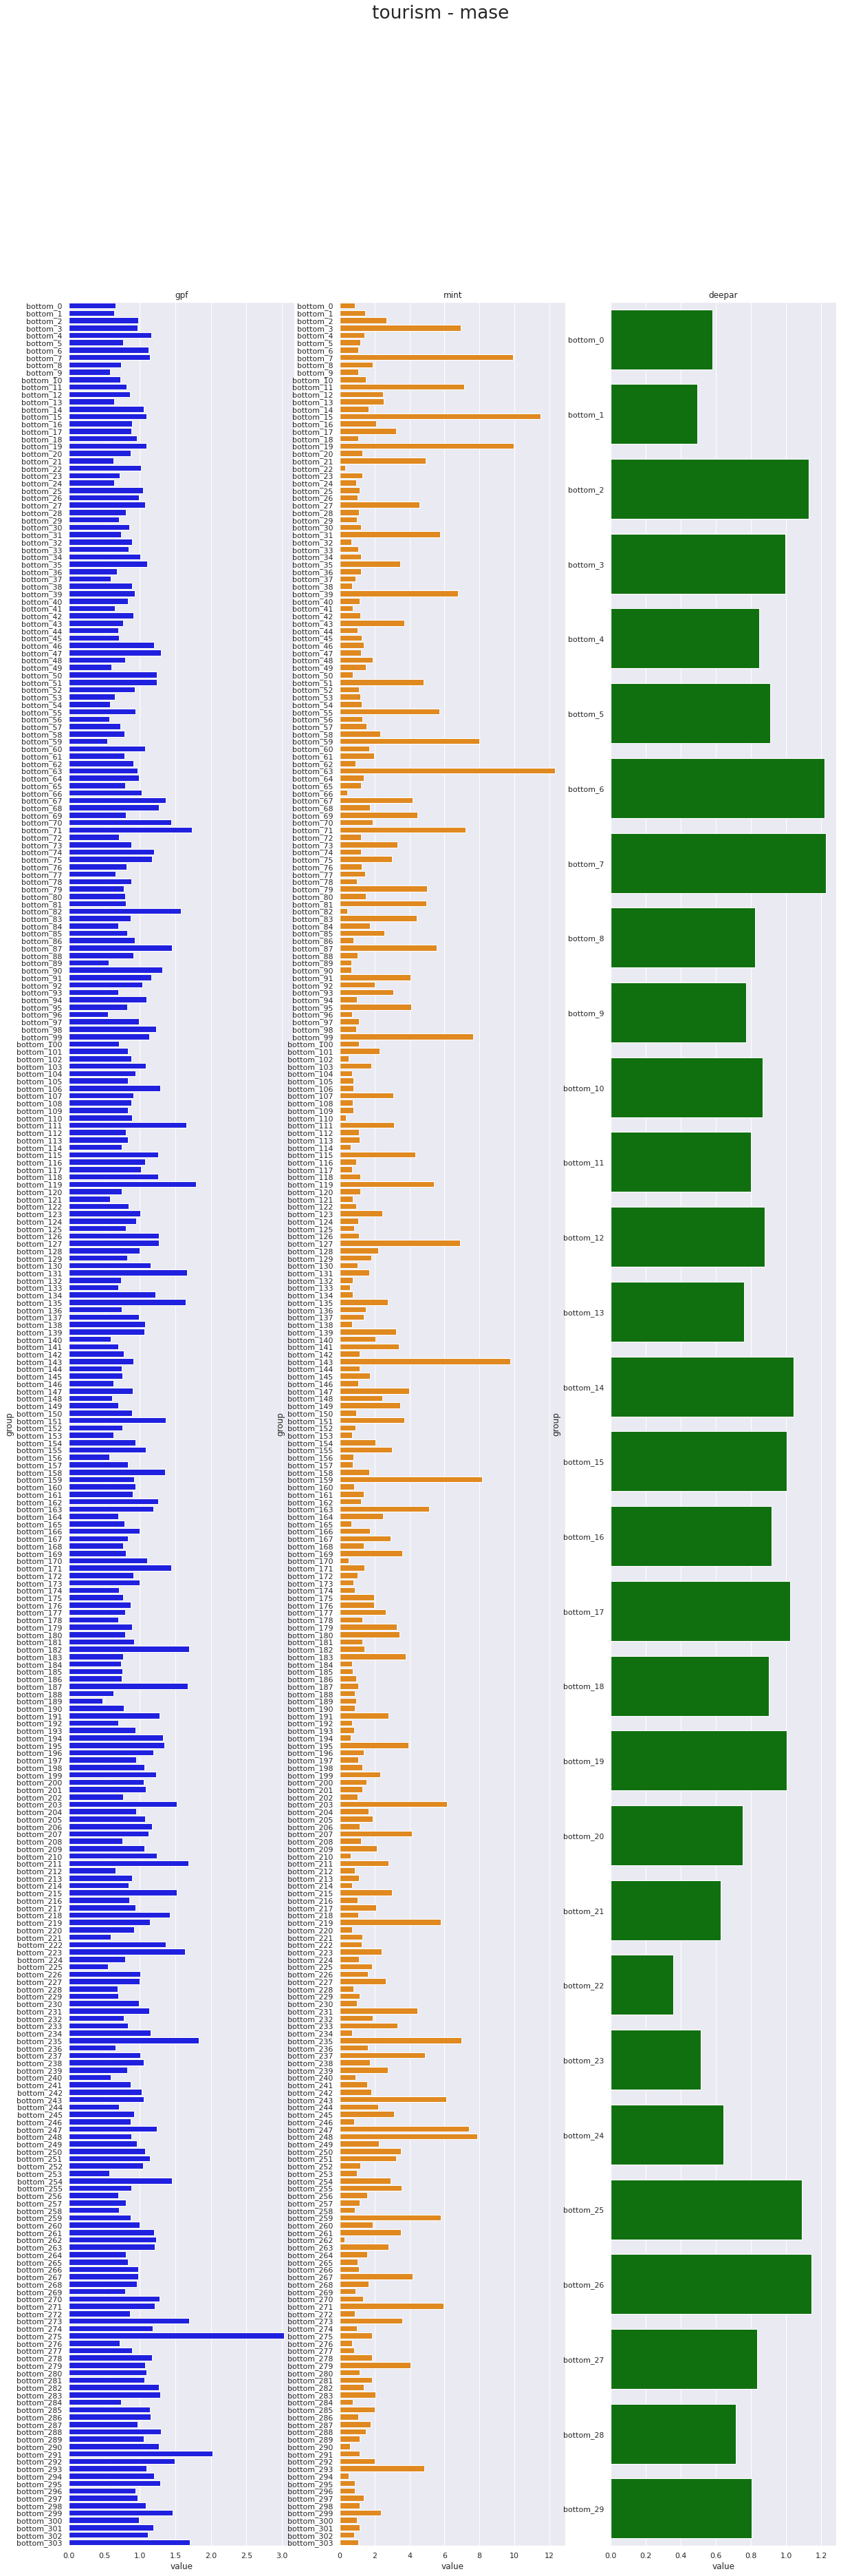

In [18]:
htsx.visualization.plot_compare_err_metric('mase', 'tourism', figsize=(20, 60))

# Calculating aggregate results for all algorithms

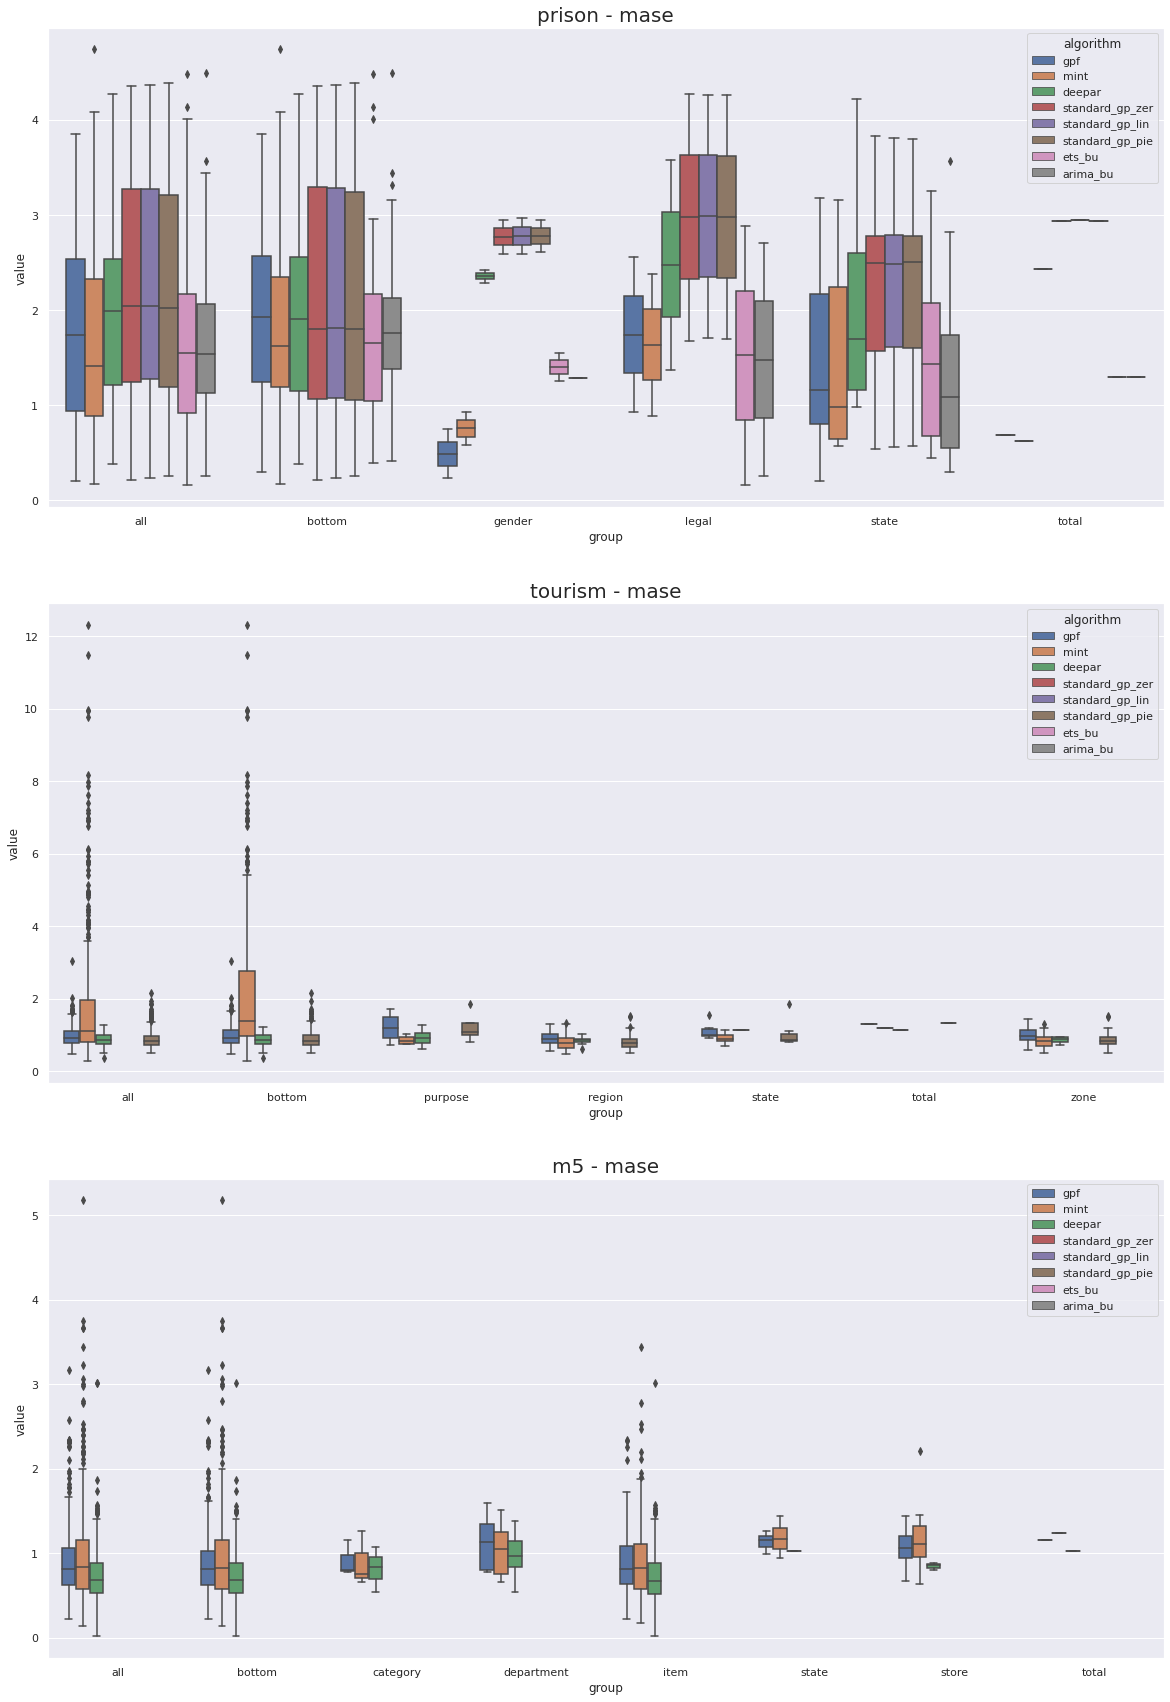

In [11]:
df_orig_list = htsx.compute_results.calculate_agg_results_all_datasets(datasets, 
                                                                       algorithms, 
                                                                       'mase')
htsx.visualization.boxplot_error(df_orig_list, 'mase', datasets)

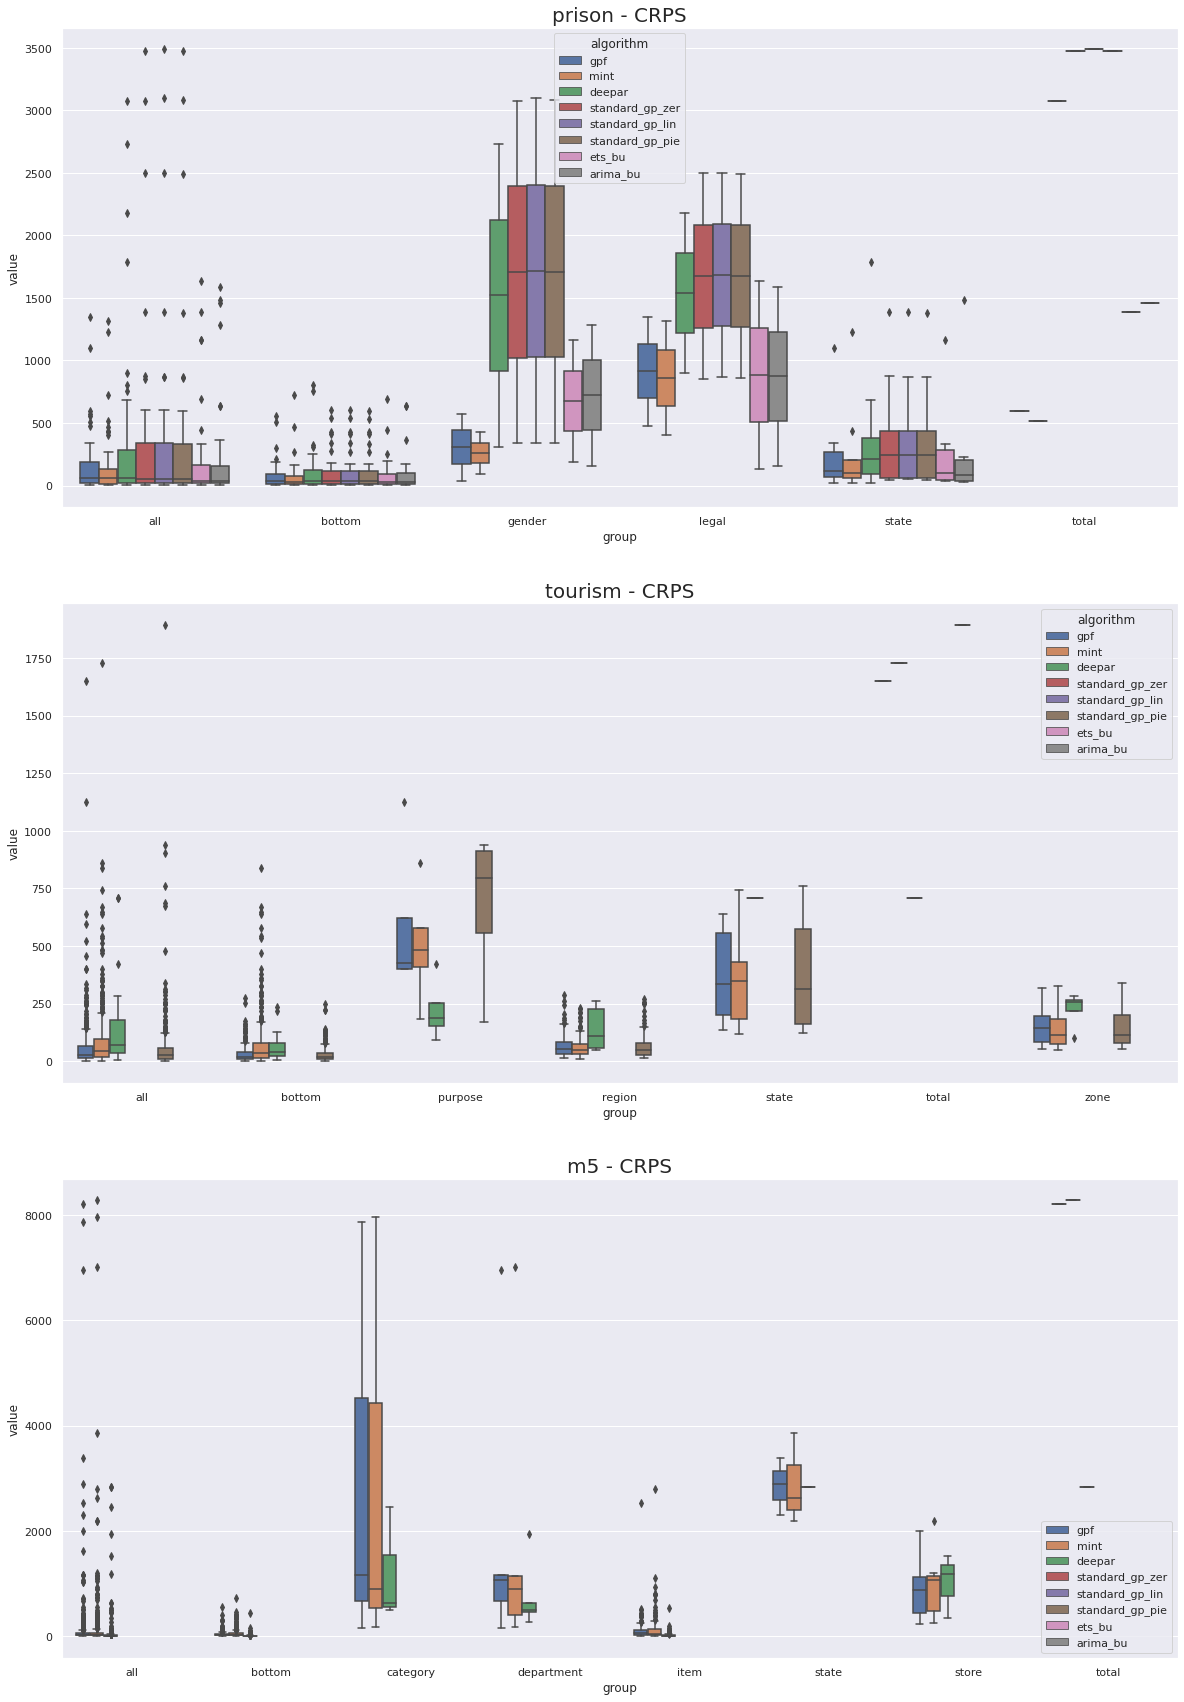

In [12]:
df_orig_list = htsx.compute_results.calculate_agg_results_all_datasets(datasets, 
                                                                       algorithms, 
                                                                       'CRPS')
htsx.visualization.boxplot_error(df_orig_list, 'CRPS', datasets)